In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
import cv2
import torchvision.transforms as T
from torchinfo import summary
from torch.optim import Adam

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_train_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, match_anchors_to_gt, filter_valid_bboxes, calculate_iou
from utils import draw_image_with_box, visualize_anchors_and_gt

In [3]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [4]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
train_dataset[1]

{'image': tensor([[[ 768.7479,  770.5604,  786.4636,  ...,  677.9993,  681.5768,
            693.4907],
          [ 780.5439,  765.8704,  768.6550,  ...,  671.7059,  672.0386,
            684.1594],
          [ 783.9877,  774.8026,  786.1138,  ...,  692.3400,  677.7738,
            682.2230],
          ...,
          [ 898.7793,  915.6559,  916.9987,  ...,  793.2844,  836.5212,
            856.9437],
          [ 880.1663,  903.0046,  911.5419,  ...,  807.2330,  829.5571,
            867.6708],
          [ 879.3508,  892.5360,  919.6151,  ...,  823.2661,  838.5450,
            863.5139]],
 
         [[ 756.5872,  752.1634,  770.4963,  ...,  690.2297,  682.5402,
            684.6046],
          [ 757.7571,  755.7731,  760.2758,  ...,  683.1895,  681.5301,
            683.8528],
          [ 758.7762,  752.0576,  753.2884,  ...,  678.7123,  673.5830,
            678.0536],
          ...,
          [ 987.6462,  995.6039,  989.6062,  ...,  844.4523,  885.6521,
            918.7747],
        

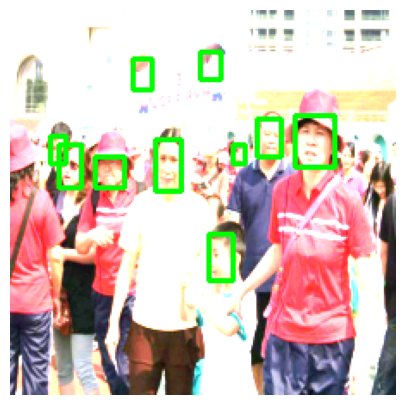

In [5]:
draw_image_with_box(train_dataset[2]['image'], train_dataset[2]['boxes'])

In [6]:
vgg16_backbone= models.vgg16(weights= models.VGG16_Weights.IMAGENET1K_V1)
features_extractor= vgg16_backbone.features

In [7]:
print(features_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [8]:
last_pool_idx= -1
for i, layer in enumerate(features_extractor):
    if isinstance(layer, nn.MaxPool2d):
        last_pool_idx= i
if last_pool_idx != -1:
    backbone_layers= list(features_extractor.children())[:last_pool_idx-1]
    vgg16_conv_features= nn.Sequential(*backbone_layers)
else:
    print('Unexpected structure taking all features from backbone')
    vgg16_conv_features= features_extractor
num_out_channels_backbone= vgg16_conv_features[-1].out_channels
vgg16_conv_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
torch.save(vgg16_conv_features, artifacts_dir + "vgg16_backbone_feat_ext.pth")

In [10]:
vgg16_conv_features= torch.load(artifacts_dir + "vgg16_backbone_feat_ext.pth")

In [11]:
image_sample= train_dataset[0]['image']
ff_output= vgg16_conv_features(image_sample)

In [12]:
image_sample.shape

torch.Size([3, 224, 224])

In [13]:
ff_output.shape

torch.Size([512, 14, 14])

In [14]:
feature_map_shape = (14, 14) # Output shape from VGG16 with 256x256 input
image_shape_resized = (224, 224) # The size your image is resized to for the model
stride = image_shape_resized[0] / feature_map_shape[0] # Stride based on RESIZED image (256 / 16 = 16)

anchor_scales = [8, 16, 24, 32, 64, 128] # Scales in pixels relative to the RESIZED image (256x256)
anchor_ratios = [0.5, 0.75, 1.0, 1.33, 2.0]

# Generate anchors using the RESIZED image shape and calculated stride
all_anchors = generate_anchor_boxes(
    feature_map_shape,
    image_shape_resized, # Use RESIZED image shape here!
    anchor_scales,
    anchor_ratios,
    stride
)
print(f"Feature map shape: {feature_map_shape}")
print(f"Resized image shape: {image_shape_resized}")
print(f"Stride: {stride}")
print(f"Scales: {anchor_scales}, Ratios: {anchor_ratios}")
print(f"Generated {all_anchors.shape[0]} anchors. Shape: {all_anchors.shape}")
print("First 5 anchors:\n", all_anchors[:5])

Feature map shape: (14, 14)
Resized image shape: (224, 224)
Stride: 16.0
Scales: [8, 16, 24, 32, 64, 128], Ratios: [0.5, 0.75, 1.0, 1.33, 2.0]
Generated 5880 anchors. Shape: torch.Size([5880, 4])
First 5 anchors:
 tensor([[0.0231, 0.0105, 0.0483, 0.0610],
        [0.0202, 0.0151, 0.0512, 0.0563],
        [0.0179, 0.0179, 0.0536, 0.0536],
        [0.0151, 0.0202, 0.0563, 0.0512],
        [0.0105, 0.0231, 0.0610, 0.0483]])


In [15]:
all_anchors

tensor([[0.0231, 0.0105, 0.0483, 0.0610],
        [0.0202, 0.0151, 0.0512, 0.0563],
        [0.0179, 0.0179, 0.0536, 0.0536],
        ...,
        [0.6786, 0.6786, 0.9955, 0.9955],
        [0.6348, 0.7165, 0.9955, 0.9955],
        [0.5602, 0.7623, 0.9955, 0.9955]])

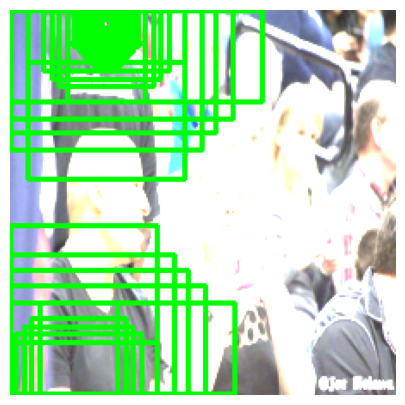

In [16]:
sample_image= train_dataset[8]['image']
sample_label= train_dataset[8]['boxes']

np_image_display= sample_image.detach().cpu().numpy()
np_image_display = np.transpose(np_image_display, (1, 2, 0)) # CxHxW to HxWxC

# Normalize to [0, 255] uint8
if np_image_display.max() <= 1.0:
    np_image_display = (np_image_display * 255).astype(np.uint8)
else:
    np_image_display = np_image_display.astype(np.uint8)

# Ensure contiguous
if not np_image_display.flags['C_CONTIGUOUS']:
    np_image_display = np.ascontiguousarray(np_image_display)

# Draw ALL anchors on the resized image
draw_image_with_box(sample_image, all_anchors[1250:1300])

In [17]:
filtered_bboxes= filter_valid_bboxes(sample_label)
iou= calculate_iou(all_anchors, filtered_bboxes)
all_anchors.shape, iou.shape, filtered_bboxes.shape

(torch.Size([5880, 4]), torch.Size([5880, 7]), torch.Size([7, 4]))

In [18]:
iou.max()

tensor(0.6896)

In [19]:
matched_targs= match_anchors_to_gt(all_anchors, sample_label)
matched_labels, regression_targets= matched_targs['labels'], matched_targs['regression_targets']
num_positive_labels= torch.sum(matched_labels==1)
num_positive_labels

tensor(8)

In [20]:
torch.where(matched_labels==1)[0]

tensor([2225, 2596, 3135, 3430, 3431, 4331, 4332, 4335])

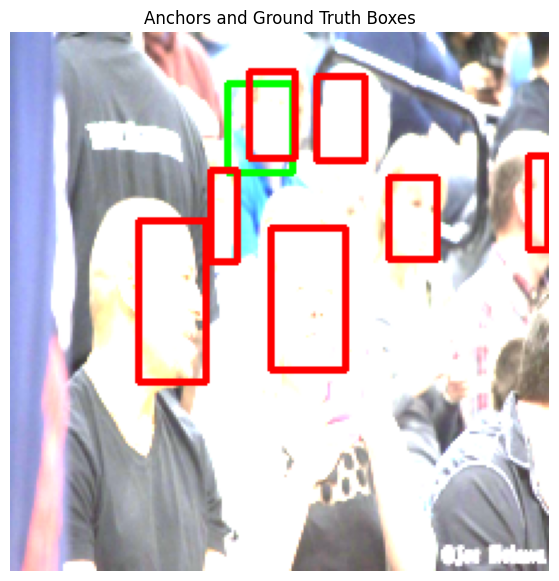

In [21]:
visualize_anchors_and_gt(sample_image, all_anchors[2596:2597], filtered_bboxes)

In [22]:
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors_per_location= 30):
        super(RPN, self).__init__()
        self.num_anchors= num_anchors_per_location
        self.in_channels= in_channels

        self.shared_conv= nn.Conv2d(in_channels, 512, kernel_size= 3, stride= 1, padding= 1)
        self.relu= nn.ReLU(inplace= True)

        self.cls_layer= nn.Conv2d(512, self.num_anchors * 1, kernel_size= 1,
                                  stride= 1, padding= 0)
        
        self.reg_layer= nn.Conv2d(512, self.num_anchors * 4, kernel_size= 1,
                                  stride= 1, padding= 0)
    
    def forward(self, x):
        # Apply shared conv to get features of region proposal
        shared_feats= self.relu(self.shared_conv(x))
        # Get classification scores
        cls_scores= self.cls_layer(shared_feats)
        # Get reg deltas
        reg_deltas= self.reg_layer(shared_feats)

        cls_scores= cls_scores.view(x.size(0), self.num_anchors, -1,
                                    x.size(2), x.size(3))
        reg_deltas= reg_deltas.view(x.size(0), self.num_anchors, -1,
                                    x.size(2), x.size(3))
        return {
            'cls_scores': cls_scores,
            'reg_deltas': reg_deltas
        }

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha= 0.25, gamma= 2.0):
        super(FocalLoss, self).__init__()
        self.alpha= alpha
        self.gamma= gamma
    def forward(self, logits, targets):
        probs= torch.sigmoid(logits)
        ce_loss= nn.BCEWithLogitsLoss(reduction= 'none')(logits, targets)
        p_t= probs * targets + (1 - probs) * (1 - targets)
        focal_loss= self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean() 

In [24]:
def rpn_loss_fn(cls_scores, reg_deltas, anchor_labels, regression_targets, device= 'cpu'):
    cls_scores= cls_scores.view(-1)
    anchor_labels= anchor_labels.view(-1)

    # Filtering ignopred anchors (-1)
    valid_mask= anchor_labels >= 0
    cls_scores_valid= cls_scores[valid_mask]
    anchor_labels_valid= anchor_labels[valid_mask]
    anchor_labels_valid= anchor_labels_valid.float().to(device)
    
    focal_loss= FocalLoss(alpha= 0.25, gamma= 2.0)
    objectness_loss= focal_loss(cls_scores_valid, anchor_labels_valid)

    reg_deltas= reg_deltas.view(-1, 4)
    regression_targets= regression_targets.view(-1, 4)

    positive_mask= anchor_labels == 1
    reg_deltas_positive= reg_deltas[positive_mask]
    regression_targets_positive= regression_targets[positive_mask]
    
    smooth_l1_loss= nn.SmoothL1Loss()
    if reg_deltas_positive.numel() > 0:
        regression_loss= smooth_l1_loss(reg_deltas_positive, regression_targets_positive)
    else:
        regression_loss= torch.tensor(1e-6, device= reg_deltas.device)
    
    lambda_reg= 10.0
    total_loss= objectness_loss + lambda_reg * regression_loss
    return {
        'objectness_loss': objectness_loss,
        'regression_loss': regression_loss,
        'total_loss': total_loss
    }


In [25]:
len(all_images[:700])

700

In [26]:
train_images, validation_images= train_test_split(all_images[:200], test_size= 0.2, random_state= 42)
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= validation_images, max_boxes= 10, transform= transforms)
len(val_dataset)

40

In [27]:
train_loader= DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= config.BATCH_SIZE, shuffle= False)

In [28]:
# device= 'cuda' if torch.cuda.is_available() else 'cpu'
# rpn.to(device)

In [29]:
# batch= next(iter(train_loader))
# images= batch['image']
# images= vgg16_conv_features(images)
# images= images.to(device)
# labels= batch['boxes']
# summary(rpn, input_data= images)

In [30]:
with torch.no_grad():
    feature_maps= vgg16_conv_features(sample_image)
rpn_model = RPN(in_channels= 512)
summary(rpn_model, input_size= (16, 512, 14, 14))

Layer (type:depth-idx)                   Output Shape              Param #
RPN                                      [16, 30, 4, 14, 14]       --
├─Conv2d: 1-1                            [16, 512, 14, 14]         2,359,808
├─ReLU: 1-2                              [16, 512, 14, 14]         --
├─Conv2d: 1-3                            [16, 30, 14, 14]          15,390
├─Conv2d: 1-4                            [16, 120, 14, 14]         61,560
Total params: 2,436,758
Trainable params: 2,436,758
Non-trainable params: 0
Total mult-adds (G): 7.64
Input size (MB): 6.42
Forward/backward pass size (MB): 16.61
Params size (MB): 9.75
Estimated Total Size (MB): 32.78

In [31]:
optimizer= Adam(rpn_model.parameters(), lr= config.LEARNING_RATE)
train_loss_history= []
val_loss_history= []
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rpn_model.to(device)
vgg16_conv_features.to(device)
for epoch in range(config.EPOCHS):
    epoch_loss= 0.0
    rpn_model.train()

    for batch in train_loader:
        images= batch['image'].to(device)
        gt_boxes= batch['boxes'].to(device)

        with torch.no_grad():
            feature_maps= vgg16_conv_features(images)
        all_anchors= generate_anchor_boxes(
            feature_map_shape= feature_maps.shape[2:4],
            image_shape= images.shape[2:4],
            scales= config.ANCHOR_SCALES,
            ratios= config.ANCHOR_RATIOS,
            stride= config.ANCHOR_STRIDE
        ).to(device)

        rpn_outputs= rpn_model(feature_maps)
        cls_scores= rpn_outputs['cls_scores']
        reg_deltas= rpn_outputs['reg_deltas']

        batch_loss= 0.0
        for i in range(images.size(0)):
            anchor_labels_and_targs= match_anchors_to_gt(
                anchor_boxes= all_anchors,
                gt_boxes= gt_boxes[i],
                iou_high_threshold= config.IOU_HIGH_THRESHOLD,
                iou_low_threshold= config.IOU_LOW_THRESHOLD,
                device= device
            )
            anchor_labels= anchor_labels_and_targs['labels']
            regression_targets= anchor_labels_and_targs['regression_targets']
            losses= rpn_loss_fn(cls_scores[i], reg_deltas[i], anchor_labels, regression_targets, device= device)
            batch_loss += losses['total_loss']

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    batch_loss /= images.size(0)
    epoch_loss += batch_loss.item()
    train_loss_history.append(epoch_loss/len(train_loader))
    print(f"Epoch: {epoch + 1} Objectness Loss Train: {losses['objectness_loss'].item():.4f} |  Regression Loss: {losses['regression_loss'].item():.4f} ")
    print(f"Epoch: {epoch + 1}/{config.EPOCHS} | Train Loss: {epoch_loss/len(train_loader):.4f}")

    rpn_model.eval()
    epoch_val_loss= 0.0
    with torch.no_grad():
        for batch in val_loader:
            images= batch['image'].to(device)
            gt_boxes= batch['boxes'].to(device)

            feature_maps= vgg16_conv_features(images)
            all_anchors= generate_anchor_boxes(
                feature_map_shape= feature_maps.shape[2:4],
                image_shape= images.shape[2:4],
                scales= config.ANCHOR_SCALES,
                ratios= config.ANCHOR_RATIOS,
                stride= config.ANCHOR_STRIDE
            ).to(device)

            rpn_outputs= rpn_model(feature_maps)
            cls_scores= rpn_outputs['cls_scores']
            reg_deltas= rpn_outputs['reg_deltas']

            batch_loss= 0.0
            for i in range(images.size(0)):
                anchor_labels_and_targs= match_anchors_to_gt(
                    anchor_boxes= all_anchors,
                    gt_boxes= gt_boxes[i],
                    iou_high_threshold= config.IOU_HIGH_THRESHOLD,
                    iou_low_threshold= config.IOU_LOW_THRESHOLD,
                    device= device
                )
                anchor_labels= anchor_labels_and_targs['labels']
                regression_targets= anchor_labels_and_targs['regression_targets']
                losses= rpn_loss_fn(
                    cls_scores[i], reg_deltas[i], anchor_labels, regression_targets,
                    device= device
                )
                batch_loss += losses['total_loss']
    print(f"Epoch: {epoch + 1} Objectness Loss Val: {losses['objectness_loss'].item():.4f} |  Regression Loss Val: {losses['regression_loss'].item():.4f} ")
    batch_loss /= images.size(0)
    epoch_val_loss += batch_loss.item()
    epoch_val_loss /= len(val_loader)
    val_loss_history.append(epoch_val_loss)

    print(f"Epoch {epoch + 1}/{config.EPOCHS}, Validation Loss: {epoch_val_loss:.4f}")

Epoch: 1 Objectness Loss Train: 54.8637 |  Regression Loss: 985.9520 
Epoch: 1/10 | Train Loss: 1617.0024
Epoch: 1 Objectness Loss Val: 96.1061 |  Regression Loss Val: 960.6395 
Epoch 1/10, Validation Loss: 6544.8490
Epoch: 2 Objectness Loss Train: 25.7643 |  Regression Loss: 465.4717 
Epoch: 2/10 | Train Loss: 608.4425
Epoch: 2 Objectness Loss Val: 26.3674 |  Regression Loss Val: 155.1070 
Epoch 2/10, Validation Loss: 1790.0469
Epoch: 3 Objectness Loss Train: 0.1575 |  Regression Loss: 8.8059 
Epoch: 3/10 | Train Loss: 7.6939
Epoch: 3 Objectness Loss Val: 0.0814 |  Regression Loss Val: 0.6915 
Epoch 3/10, Validation Loss: 5.8362
Epoch: 4 Objectness Loss Train: 0.0430 |  Regression Loss: 0.0150 
Epoch: 4/10 | Train Loss: 0.0293
Epoch: 4 Objectness Loss Val: 0.0431 |  Regression Loss Val: 0.0177 
Epoch 4/10, Validation Loss: 0.1965
Epoch: 5 Objectness Loss Train: 0.0434 |  Regression Loss: 0.0229 
Epoch: 5/10 | Train Loss: 0.0453
Epoch: 5 Objectness Loss Val: 0.0427 |  Regression Loss V

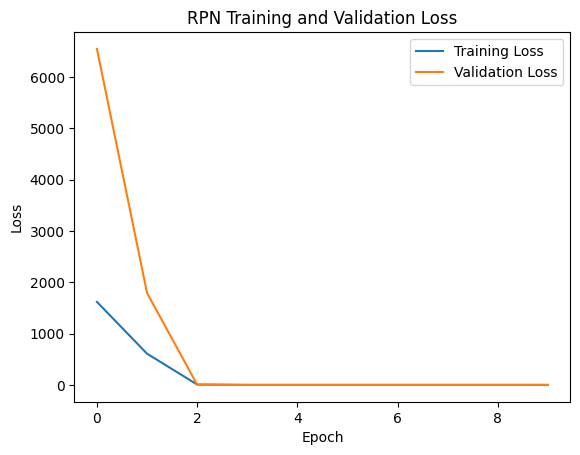

In [32]:
plt.plot(train_loss_history, label= "Training Loss")
plt.plot(val_loss_history, label= "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RPN Training and Validation Loss")
plt.legend()
plt.show()

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg16_conv_features = torch.load(artifacts_dir + "vgg16_backbone_feat_ext.pth")
# vgg16_conv_features.to(device)
rpn_model.eval()

all_precisions = []
all_recalls = []
all_average_precisions = []
loss_history = []

with torch.no_grad():
    for batch in train_loader:
        images = batch['image'].to(device)
        gt_boxes = batch['boxes'].to(device)

        feature_maps = vgg16_conv_features(images)
        all_anchors = generate_anchor_boxes(
            feature_map_shape=feature_maps.shape[2:4],
            image_shape=images.shape[2:4],
            scales=config.ANCHOR_SCALES,
            ratios=config.ANCHOR_RATIOS,
            stride=config.ANCHOR_STRIDE
        ).to(device)

        rpn_outputs = rpn_model(feature_maps.to(device))
        cls_scores = rpn_outputs['cls_scores']
        reg_deltas = rpn_outputs['reg_deltas']

        for i in range(images.size(0)):
            anchor_labels_and_targets = match_anchors_to_gt(
                anchor_boxes=all_anchors,
                gt_boxes=gt_boxes[i],
                iou_high_threshold=config.IOU_HIGH_THRESHOLD,
                iou_low_threshold=config.IOU_LOW_THRESHOLD,
                device=device
            )
            anchor_labels = anchor_labels_and_targets['labels']
            regression_targets = anchor_labels_and_targets['regression_targets']
            cls_probs = torch.sigmoid(cls_scores[i].view(-1))

            # Debugging: Print probabilities
            print(f"Classification probabilities: {cls_probs[:10]}")

            # Adjust threshold for positive anchors
            positive_indices = torch.where(cls_probs > 0.5)[0]
            predicted_boxes = all_anchors[positive_indices]

            # Handle empty ground truth boxes
            if gt_boxes[i].numel() == 0:
                print("No ground truth boxes for this image.")
                continue

            # Compute metrics
            iou_matrix = calculate_iou(predicted_boxes, gt_boxes[i])
            print(f"IOU Matrix: {iou_matrix}")  # Debugging

            true_positives = (iou_matrix.max(dim=1).values > 0.5).sum().item()
            false_positives = len(positive_indices) - true_positives
            false_negatives = gt_boxes[i].size(0) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            all_precisions.append(precision)
            all_recalls.append(recall)
            average_precision = precision * recall
            all_average_precisions.append(average_precision)

            # Compute loss
            losses = rpn_loss_fn(cls_scores[i], reg_deltas[i], anchor_labels, regression_targets, device=device)
            loss_history.append(losses['total_loss'].item())

            print(f"Objectness Loss: {losses['objectness_loss'].item():.4f} | Reg Loss: {losses['regression_loss'].item():.4f}")

    mean_precision = sum(all_precisions) / len(all_precisions)
    mean_recall = sum(all_recalls) / len(all_recalls)
    mean_average_precision = sum(all_average_precisions) / len(all_average_precisions)

    metrics = {
        'precision': mean_precision,
        'recall': mean_recall,
        'mAP': mean_average_precision
    }

    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Mean Average Precision (mAP): {metrics['mAP']:.4f}")
    print(f"Average Loss: {sum(loss_history) / len(loss_history):.4f}")

Classification probabilities: tensor([0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769,
        0.4769], device='cuda:0')
IOU Matrix: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Objectness Loss: 0.0400 | Reg Loss: 0.0128
Classification probabilities: tensor([0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769, 0.4769,
        0.4769], device='cuda:0')
IOU Matrix: tensor([[0.0785, 0.0000, 0.0747,  ..., 0.0000, 0.0000, 0.0000],
        [0.0350, 0.0000, 0.0705,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.

In [34]:
min(loss_history)

0.0977085679769516

In [35]:
max(loss_history)

2.490098476409912

In [43]:
positives= torch.where(cls_probs > 0.8)
positives[0].shape

torch.Size([21])

In [44]:
torch.sum(anchor_labels==1).item()

8

In [45]:
predicted_boxes.shape

torch.Size([422, 4])

In [39]:
cls_scores

tensor([[[[[-0.0925, -0.0925, -0.0925,  ..., -0.0925, -0.0925, -0.0925],
           [-0.0925, -0.0925, -0.0925,  ..., -0.0925, -0.0925, -0.0925],
           [-0.0925, -0.0925, -0.0925,  ..., -0.0925, -0.0925, -0.0925],
           ...,
           [-0.0925, -0.0925, -0.0925,  ..., -0.0925, -0.0925, -0.0925],
           [-0.0925, -0.0925, -0.0925,  ..., -0.0925, -0.0925, -0.0925],
           [-0.0925, -0.0925, -0.0925,  ..., -0.0925, -0.0925, -0.0925]]],


         [[[-0.0967, -0.0967, -0.0967,  ..., -0.0967, -0.0967, -0.0967],
           [-0.0967, -0.0967, -0.0967,  ..., -0.0967, -0.0967, -0.0967],
           [-0.0967, -0.0967, -0.0967,  ..., -0.0967, -0.0967, -0.0967],
           ...,
           [-0.0967, -0.0967, -0.0967,  ..., -0.0967, -0.0967, -0.0967],
           [-0.0967, -0.0967, -0.0967,  ..., -0.0967, -0.0967, -0.0967],
           [-0.0967, -0.0967, -0.0967,  ..., -0.0967, -0.0967, -0.0967]]],


         [[[-0.0204, -0.0204, -0.0204,  ..., -0.0204, -0.0204, -0.0204],
           

In [40]:
max(cls_probs)

tensor(1.0000, device='cuda:0')

In [41]:
print(iou_matrix.shape)

torch.Size([422, 10])


In [47]:
cls_probs.shape

torch.Size([5880])

In [67]:
sample_image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [82]:
def test_model(model, backbone, image, device='cuda'):
    # Load and preprocess the image
    original_height, original_width = image.shape[1:3]

    # Extract feature maps using the backbone
    with torch.no_grad():
        feature_maps = backbone(image.to(device))
    print(feature_maps.shape[1:3])
    # Generate anchors
    all_anchors = generate_anchor_boxes(
        feature_map_shape=feature_maps.shape[2:4],
        image_shape=(original_height, original_width),
        scales=config.ANCHOR_SCALES,
        ratios=config.ANCHOR_RATIOS,
        stride=config.ANCHOR_STRIDE
    ).to(device)

    # Run the RPN model
    model.eval()
    with torch.no_grad():
        rpn_outputs = model(feature_maps)
        cls_scores = rpn_outputs['cls_scores'].squeeze(0)  # Remove batch dimension
        reg_deltas = rpn_outputs['reg_deltas'].squeeze(0)  # Remove batch dimension

    # Convert classification scores to probabilities
    cls_probs = torch.sigmoid(cls_scores.view(-1))

    # Filter positive anchors (e.g., threshold = 0.5)
    positive_indices = torch.where(cls_probs > 0.7)[0]
    positive_anchors = all_anchors[positive_indices]

    # Apply regression deltas to refine the positive anchors
    reg_deltas_positive = reg_deltas.view(-1, 4)[positive_indices]
    anchor_widths = positive_anchors[:, 2] - positive_anchors[:, 0]
    anchor_heights = positive_anchors[:, 3] - positive_anchors[:, 1]
    anchor_centers_x = positive_anchors[:, 0] + 0.5 * anchor_widths
    anchor_centers_y = positive_anchors[:, 1] + 0.5 * anchor_heights

    refined_centers_x = anchor_centers_x + reg_deltas_positive[:, 0] * anchor_widths
    refined_centers_y = anchor_centers_y + reg_deltas_positive[:, 1] * anchor_heights
    refined_widths = anchor_widths * torch.exp(reg_deltas_positive[:, 2])
    refined_heights = anchor_heights * torch.exp(reg_deltas_positive[:, 3])

    refined_boxes = torch.zeros_like(positive_anchors)
    refined_boxes[:, 0] = refined_centers_x - 0.5 * refined_widths
    refined_boxes[:, 1] = refined_centers_y - 0.5 * refined_heights
    refined_boxes[:, 2] = refined_centers_x + 0.5 * refined_widths
    refined_boxes[:, 3] = refined_centers_y + 0.5 * refined_heights

    # Clip refined boxes to image boundaries
    refined_boxes[:, 0] = torch.clamp(refined_boxes[:, 0], min=0, max=original_width - 1)
    refined_boxes[:, 1] = torch.clamp(refined_boxes[:, 1], min=0, max=original_height - 1)
    refined_boxes[:, 2] = torch.clamp(refined_boxes[:, 2], min=0, max=original_width - 1)
    refined_boxes[:, 3] = torch.clamp(refined_boxes[:, 3], min=0, max=original_height - 1)
    return refined_boxes

In [83]:
predicted_boxes= test_model(rpn_model, vgg16_conv_features, sample_image.unsqueeze(0), device)
predicted_boxes.shape

torch.Size([512, 14])


torch.Size([12, 4])

In [89]:
predicted_boxes

tensor([[0.0018, 0.6667, 0.1236, 0.6667],
        [0.0828, 0.6667, 0.1351, 0.6667],
        [0.0074, 0.6667, 0.2119, 0.6667],
        [0.1474, 0.6667, 0.2087, 0.6667],
        [0.2090, 0.6667, 0.2918, 0.6667],
        [0.0479, 0.6667, 0.4518, 0.6667],
        [0.0743, 0.6667, 0.7559, 0.6667],
        [0.4021, 0.6667, 0.5253, 0.6667],
        [0.5177, 0.6667, 0.5532, 0.6667],
        [0.7085, 0.6667, 0.7901, 0.6667],
        [0.5648, 0.6667, 0.9687, 0.6667],
        [0.5559, 0.6667, 0.9737, 0.6667]], device='cuda:0')

In [90]:
sample_label

tensor([[0.2366, 0.3482, 0.3616, 0.6473],
        [0.3705, 0.2545, 0.4196, 0.4241],
        [0.4420, 0.0714, 0.5268, 0.2321],
        [0.4821, 0.3616, 0.6205, 0.6250],
        [0.5670, 0.0804, 0.6562, 0.2366],
        [0.7009, 0.2679, 0.7902, 0.4196],
        [0.9598, 0.2277, 0.9955, 0.4018],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])

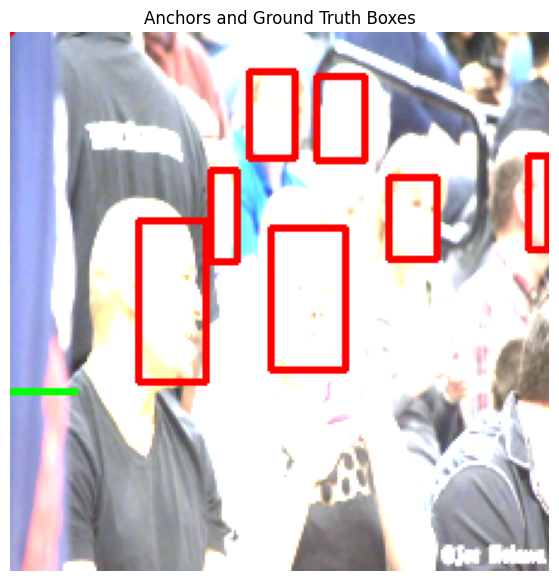

In [88]:
visualize_anchors_and_gt(sample_image, predicted_boxes[0:1], sample_label)